In [2]:
import pandas as pd

#Load the dataset
file_path = "../Data/heart_disease_uci.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

#Display basic info
print(df.info())
df.describe()
df.head()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
None


(920, 15)

In [3]:
#Maybe we should clean the data set first

#Checking for missing values  
print(df.isnull().sum())

#Drop columns with too many missing values
df = df.drop(columns=['ca', 'thal', 'slope'])

#Fill missing values in numerical columns with the median
df['trestbps'] = df['trestbps'].fillna(df['trestbps'].median())
df['chol'] = df['chol'].fillna(df['chol'].median())
df['thalch'] = df['thalch'].fillna(df['thalch'].median())
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].median())

#Fill missing values in categorical columns with the mode (most frequent value)
df['fbs'] = df['fbs'].fillna(df['fbs'].mode()[0])
df['restecg'] = df['restecg'].fillna(df['restecg'].mode()[0])
df['exang'] = df['exang'].fillna(df['exang'].mode()[0])

#Dropping any duplicate rows if there are any
df = df.drop_duplicates()

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


/var/folders/5z/qnp61f1960z4thyjbcs935hc0000gn/T/ipykernel_88782/1727642912.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fbs'] = df['fbs'].fillna(df['fbs'].mode()[0])
/var/folders/5z/qnp61f1960z4thyjbcs935hc0000gn/T/ipykernel_88782/1727642912.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['exang'] = df['exang'].fillna(df['exang'].mode()[0])


In [4]:
#First I'll prepare the data for regression 
from sklearn.model_selection import train_test_split
#Define the features (X) and the target (y)

X = df.drop(columns=['chol', 'num']) #Here we're excluding 'chol' and 'num'
y = df['chol']  #Target variable for regression

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(734, 10)
(184, 10)


In [5]:
#Checking to see if there are categorical features
# print(X_train.dtypes)

#There are so we will convert to numerical using one-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

#making sure both train and test sets have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

#checking that all columns are now numerical
print(X_train.dtypes)
print(X_train.head())

age                           int64
trestbps                    float64
fbs                            bool
thalch                      float64
exang                          bool
oldpeak                     float64
sex_Male                       bool
dataset_Hungary                bool
dataset_Switzerland            bool
dataset_VA Long Beach          bool
cp_atypical angina             bool
cp_non-anginal                 bool
cp_typical angina              bool
restecg_normal                 bool
restecg_st-t abnormality       bool
dtype: object
     age  trestbps    fbs  thalch  exang  oldpeak  sex_Male  dataset_Hungary  \
796   49     130.0  False   145.0  False      3.0      True            False   
25    50     120.0  False   158.0  False      1.6     False            False   
84    52     120.0  False   172.0  False      0.2      True            False   
10    57     140.0  False   148.0  False      0.4      True            False   
344   40     140.0  False   172.0  False      

In [6]:
#trying to get the best line!
#Next I'll train and evaluate Elasticnet Regression 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#defining the hyperparameters
alpha = 0.1  # Regularization strength
l1_ratio = 0.5  # Balance between L1 and L2 (0 = Ridge, 1 = Lasso)

#train ElasticNet model
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
elastic_net.fit(X_train, y_train)

#predictions
y_pred = elastic_net.predict(X_test)

#evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(r2)
print(rmse)

0.5449974706704088
74.11363218602817


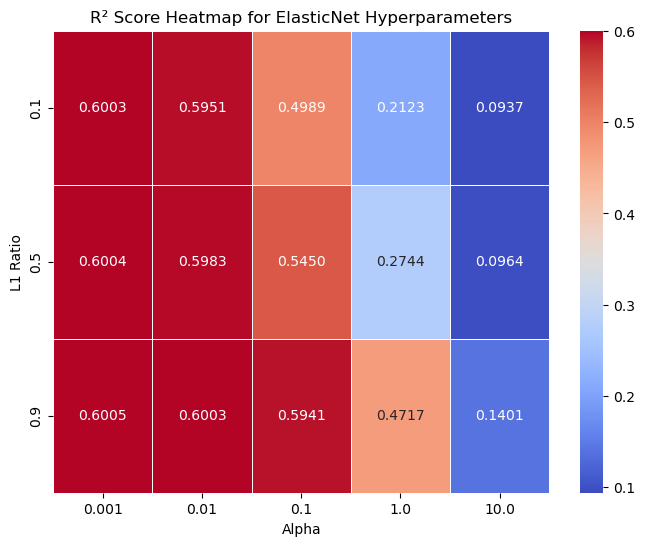

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#Okay now we'll create a heatmap to identify the top-performing configuration based on the evaluation metrics

#different hyperparameter ranges
alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

#store the results
results = []

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append((alpha, l1_ratio, r2, rmse))

#convert into DF
results_df = pd.DataFrame(results, columns=['alpha', 'l1_ratio', 'R²', 'RMSE'])

#heatmap
pivot_table = results_df.pivot(index='l1_ratio', columns='alpha', values='R²')

#plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("R² Score Heatmap for ElasticNet Hyperparameters")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.show()

In [8]:
#Training the final ElasticNet model using the best hyperparameters determined from the heatmap 
best_alpha = 0.001
best_l1_ratio = 0.9

final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
final_model.fit(X_train, y_train)


y_pred_final = final_model.predict(X_test)

#evaluating the final model
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(final_r2)
print(final_rmse)

#the top-performing configuration based on the evaluation metrics are when alpha is 0.001 and the l1 ration is 0.9

0.6004839312457372
69.4477721236744


In [18]:
#classification task 

#converting 'num' to binary (0 = No Heart Disease, 1+ = Heart Disease)
df['num'] = (df['num'] > 0).astype(int)

#define the features --> chol and num and target --> num
X_class = df.drop(columns=['chol', 'num'])  # Drop regression target 'chol'
y_class = df['num']

#train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

#check class distribution
print(y_train_class.value_counts(normalize=True))
print(y_test_class.value_counts(normalize=True))


num
1    0.553134
0    0.446866
Name: proportion, dtype: float64
num
1    0.554348
0    0.445652
Name: proportion, dtype: float64


In [ ]:
#next is training a logestic regression model to see whether a patient has heart disease or not 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc


#making sure I convert categorical features into binary indicators:
X_train_class = pd.get_dummies(X_train_class, drop_first=True)
X_test_class = pd.get_dummies(X_test_class, drop_first=True)

log_reg = LogisticRegression(max_iter=1000, random_state=42)

#train the model
log_reg.fit(X_train_class, y_train_class)

#predictions
y_pred_class = log_reg.predict(X_test_class)
y_pred_proba = log_reg.predict_proba(X_test_class)[:, 1] 

#evaluating the model
accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
roc_auc = roc_auc_score(y_test_class, y_pred_proba)

#calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test_class, y_pred_proba)

#calculate the area under the precision-recall curve
auprc = auc(recall, precision)

#Printing the results 
print(accuracy)
print(f1)
print(roc_auc)
print(auprc)

0.8369565217391305
0.8584905660377359
0.9293400286944046
0.9479454003308391


In [43]:
#Now I'll experiement with different parameters (penalty and solver) observing their effects on model coefficients and performance

penalties = ['l1', 'l2', 'elasticnet', 'none']
solvers = ['liblinear', 'saga']

log_results = []
for penalty in penalties:
    for solver in solvers:
        if penalty == 'none' and solver != 'lbfgs':
            continue  
        if penalty == 'elasticnet' and solver != 'saga':
            continue  
        
        try:
            log_reg = LogisticRegression(penalty=penalty, solver=solver, max_iter=1000, random_state=42)
            log_reg.fit(X_train_class, y_train_class)
            y_pred_log = log_reg.predict(X_test_class)
            y_pred_proba_log = log_reg.predict_proba(X_test_class)[:, 1]
            
            accuracy = accuracy_score(y_test_class, y_pred_log)
            f1 = f1_score(y_test_class, y_pred_log)
            roc_auc = roc_auc_score(y_test_class, y_pred_proba_log)
            precision, recall, _ = precision_recall_curve(y_test_class, y_pred_proba_log)
            auprc = auc(recall, precision)
            
            log_results.append((penalty, solver, accuracy, f1, roc_auc, auprc))
        except Exception as e:
            print("error with penalty and solver", e)

log_results_df = pd.DataFrame(log_results, columns=['Penalty', 'Solver', 'Accuracy', 'F1', 'AUROC', 'AUPRC'])
print(log_results_df)

error with penalty and solver l1_ratio must be specified when penalty is elasticnet.
  Penalty     Solver  Accuracy        F1     AUROC     AUPRC
0      l1  liblinear  0.842391  0.861244  0.930177  0.948979
1      l1       saga  0.793478  0.819048  0.891679  0.915675
2      l2  liblinear  0.842391  0.862559  0.929220  0.948089
3      l2       saga  0.793478  0.819048  0.891559  0.915610


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
#Tuning the hyperparameter n_neighbors (e.g., {1, 5, 10}) and comparing its impact on evaluation metrics
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 5, 10]
knn_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_class, y_train_class)
    y_pred_knn = knn.predict(X_test_class)
    y_pred_proba_knn = knn.predict_proba(X_test_class)[:, 1]
    
    accuracy = accuracy_score(y_test_class, y_pred_knn)
    f1 = f1_score(y_test_class, y_pred_knn)
    roc_auc = roc_auc_score(y_test_class, y_pred_proba_knn)
    precision, recall, _ = precision_recall_curve(y_test_class, y_pred_proba_knn)
    auprc = auc(recall, precision)
    
    knn_results.append((k, accuracy, f1, roc_auc, auprc))

knn_results_df = pd.DataFrame(knn_results, columns=['k', 'Accuracy', 'F1', 'AUROC', 'AUPRC'])
print(knn_results_df)

    k  Accuracy        F1     AUROC     AUPRC
0   1  0.581522  0.613065  0.579507  0.724866
1   5  0.641304  0.691589  0.637912  0.671173
2  10  0.635870  0.673171  0.684780  0.700079


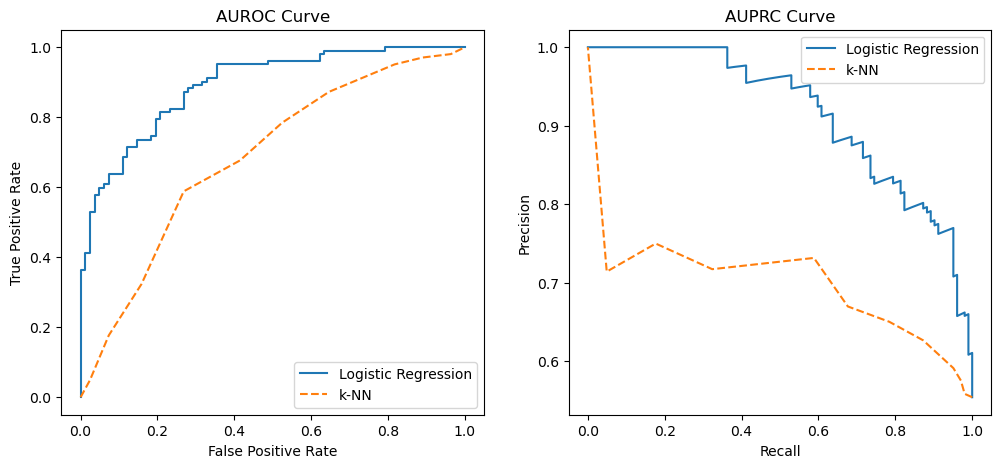

In [46]:
#Finally, plotting AUROC and AUPRC curves for the model’s best configuration
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#metrics for best logistic regression model
fpr_log, tpr_log, _ = roc_curve(y_test_class, y_pred_proba_log)
precision_log, recall_log, _ = precision_recall_curve(y_test_class, y_pred_proba_log)

#metrics for best k-NN model
fpr_knn, tpr_knn, _ = roc_curve(y_test_class, y_pred_proba_knn)
precision_knn, recall_knn, _ = precision_recall_curve(y_test_class, y_pred_proba_knn)

#plotting AUROC and AUPRC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn, label='k-NN', linestyle='dashed')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_log, precision_log, label='Logistic Regression')
plt.plot(recall_knn, precision_knn, label='k-NN', linestyle='dashed')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUPRC Curve")
plt.legend()

plt.show()